## Aligning bathymetry

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from coralshift.plotting import spatial_plots
from coralshift.processing import spatial_data

In [23]:
from pathlib import Path
import xarray as xa
import rasterio
from rasterio.merge import merge

# path to dataset folder
bathymetry_dir_path = Path("/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/temp_datasets/bathymetry")

In [19]:
# open 30m tifs into memory for merging: in the end this just takes too long and isn't scalable. Need to sort out batching. 
tifs_fp_list = [file for file in Path(bathymetry_dir_path / "GBR_30m").glob("*.tif")]
open_tifs = []

for fp in tifs_fp_list:
    src = rasterio.open(fp)
    open_tifs.append(src)

In [6]:
# GEBCO
gebco_path = bathymetry_dir_path / "GEBCO_27_Oct_2023_b803f558cd82/gebco_2023_n-10.0_s-40.0_w140.0_e160.0.nc"

gebco_nc = spatial_data.process_xa_d(xa.open_dataarray(gebco_path))
# gebco_nc["elevation"].plot()
spatial_plots.plot_spatial(gebco_nc["elevation"])

KeyError: 'elevation'

In [4]:
import rioxarray as rio


def chunk_as_necessary(
    xa_d: xa.DataArray | xa.Dataset, chunk_dict: dict
) -> xa.DataArray | xa.Dataset:
    """
    Chunk the input xarray DataArray or Dataset along the specified dimensions according to the given chunk dictionary.

    Parameters
    -----------
        xa_d (xa.DataArray or xa.Dataset): The xarray DataArray or Dataset to be chunked.
        chunk_dict (dict): A dictionary specifying the chunk size for each dimension.
                           The keys are the dimension names, and the values are the desired chunk sizes.
                           If a dimension is not present in the dictionary or its value is None,
                           that dimension will not be chunked.

    Returns
    -------
        xa.DataArray or xa.Dataset: The chunked xarray DataArray or Dataset.

    """
    # set up to chunk relevant coordinates
    dims_to_chunk = {dim: chunk_dict.get(dim, None) for dim in xa_d.dims}
    return xa_d.chunk(dims_to_chunk)


def process_xa_d(
    xa_d: xa.Dataset | xa.DataArray,
    rename_mapping: dict = {
        "lat": "latitude",
        "lon": "longitude",
        "y": "latitude",
        "x": "longitude",
    },
    squeeze_coords: str | list[str] = None,
    chunk_dict: dict = {"latitude": 100, "longitude": 100, "time": 100},
    crs: str = "EPSG:4326",
):
    """
    Process the input xarray Dataset or DataArray by standardizing coordinate names, squeezing dimensions,
    chunking along specified dimensions, and sorting coordinates.

    Parameters
    ----------
        xa_d (xa.Dataset or xa.DataArray): The xarray Dataset or DataArray to be processed.
        rename_mapping (dict, optional): A dictionary specifying the mapping for coordinate renaming.
            The keys are the existing coordinate names, and the values are the desired names.
            Defaults to a mapping that standardizes common coordinate names.
        squeeze_coords (str or list of str, optional): The coordinates to squeeze by removing size-1 dimensions.
                                                      Defaults to ['band'].
        chunk_dict (dict, optional): A dictionary specifying the chunk size for each dimension.
                                     The keys are the dimension names, and the values are the desired chunk sizes.
                                     Defaults to {'latitude': 100, 'longitude': 100, 'time': 100}.

    Returns
    -------
        xa.Dataset or xa.DataArray: The processed xarray Dataset or DataArray.

    """
    temp_xa_d = xa_d.copy()

    for coord, new_coord in rename_mapping.items():
        if new_coord not in temp_xa_d.coords and coord in temp_xa_d.coords:
            temp_xa_d = temp_xa_d.rename({coord: new_coord})

    # should these be less catch-all?
    if "band" in temp_xa_d.dims:
        temp_xa_d = temp_xa_d.squeeze("band")
    if squeeze_coords:
        temp_xa_d = temp_xa_d.squeeze(squeeze_coords)
    if "time" in temp_xa_d.dims:
        temp_xa_d = temp_xa_d.transpose("time", "latitude", "longitude", ...)
    else:
        temp_xa_d = temp_xa_d.transpose("latitude", "longitude")
    if "grid_mapping" in xa_d.attrs:
        del xa_d.attrs["grid_mapping"]
        
    # add crs
    # temp_xa_d.rio.write_crs(crs, inplace=True)
    chunked_xa_d = chunk_as_necessary(temp_xa_d, chunk_dict)
    # sort coords by ascending values
    return chunked_xa_d.sortby(list(temp_xa_d.dims))

(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'elevation at $0.0042^\\circ$ (~452 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x161888260>)

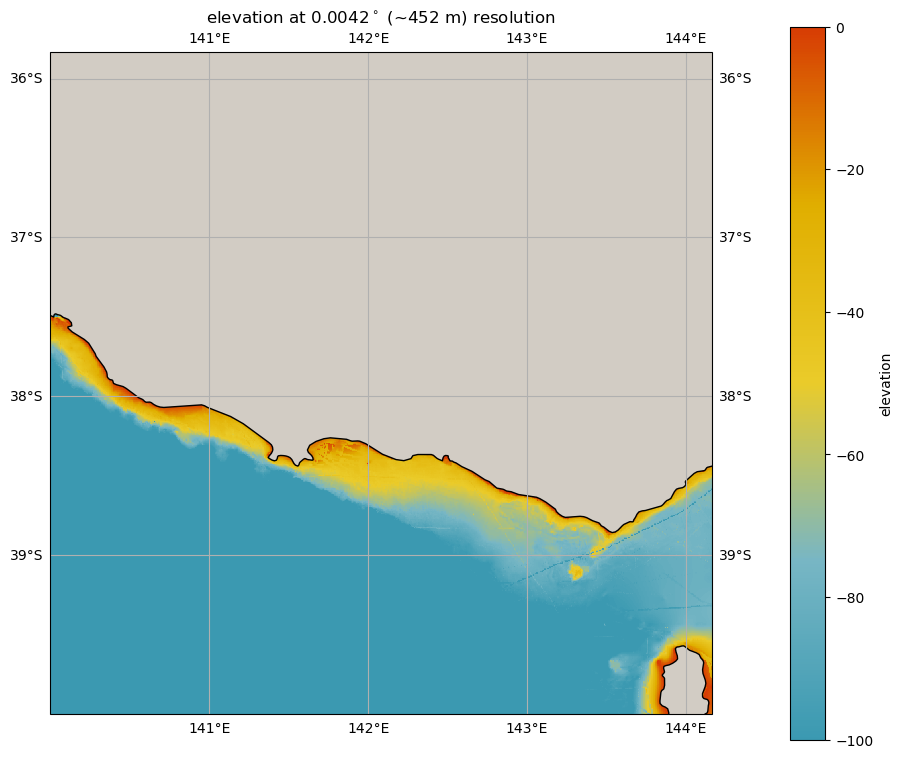

In [14]:
gebco_nc = xa.open_dataarray(gebco_path)
spatial_plots.plot_spatial(process_xa_d(gebco_nc.isel(lat=slice(0,1000), lon=slice(0,1000))), val_lims=[-100,0])